In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 


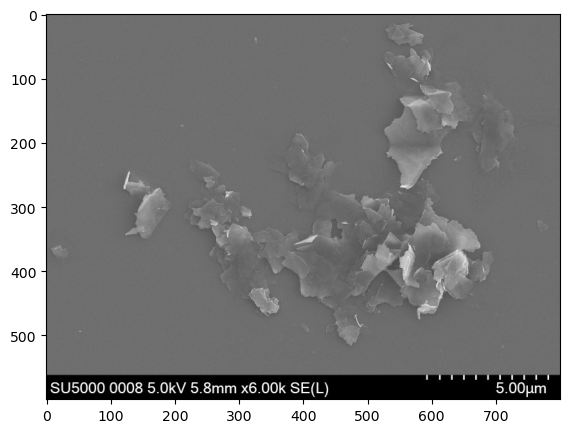

In [3]:
onnx_model_path = "onnx_model/sam_onnx_example.onnx"
image = cv2.imread(r"image/2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

ort_session = onnxruntime.InferenceSession(onnx_model_path)

sam.to(device='cpu')
predictor = SamPredictor(sam)
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape

(1, 256, 64, 64)

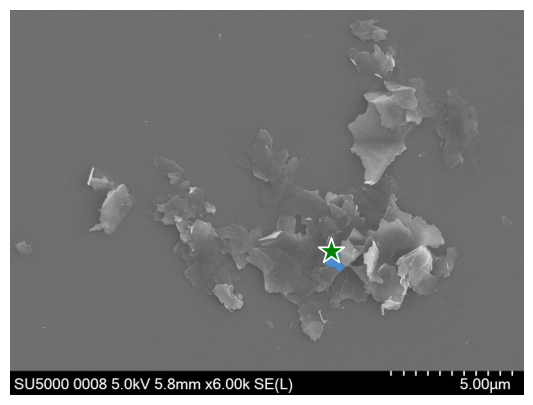

In [5]:
# Example point input
input_point = np.array([[500, 375]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

plt.figure(figsize=(10,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

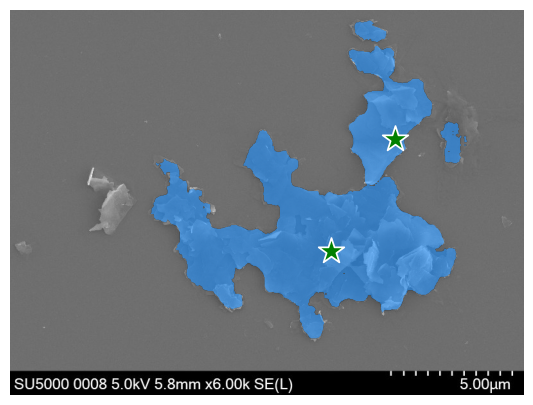

In [9]:
# Example mask input
input_point = np.array([[500, 375], [600, 200]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_has_mask_input = np.ones(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

plt.figure(figsize=(10,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

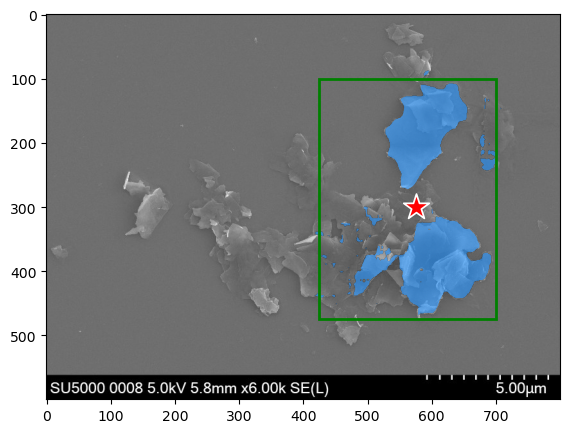

In [7]:
input_box = np.array([425, 100, 700, 475])
input_point = np.array([[575, 300]])
input_label = np.array([0])

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

plt.figure(figsize=(10, 5))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()